# Analysis of the tide and wave condition for each bathyemtric surveys 

We have 4 surveys containing bathymetric and topographic data for the site of Biarritz between 2017 and nowadays:

- 27/03/2017
- 31/01/2018
- 03/03/2021
- 21/06/2021

## Import modules

In [1]:
import glob
import numpy as np
import pandas as pd
from itertools import chain
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 

## Bathymetric survey dates

In [2]:
bathy_date = ['2017-03-27', '2018-01-31', '2021-03-03', '2021-06-21']
bathy_date =  pd.to_datetime(bathy_date)

In [3]:
def seq_from_date(date, nb_days):
    res = pd.DataFrame()
    res['Date'] = pd.date_range(start=date - timedelta(days=nb_days),
              end=date + timedelta(days=nb_days),
             freq='1H')
    res['Bathy'] = date.strftime("%Y/%m/%d")
    return(res)

res_list = list(map(lambda x: seq_from_date(x, 15), bathy_date))
date_seq = pd.DataFrame(np.vstack(res_list))
date_seq = date_seq.rename(columns= {0: 'Date',
                       1: 'Bathy'})

day_list =  np.unique(date_seq['Date'].apply(lambda x: x.to_pydatetime().date()))

## Import data 
### Observed tide data 

In [4]:
tide_file = glob.glob('./Data/*.txt')
res = []
for file in tide_file:
    res.append(pd.read_csv(file, skiprows=14, sep=';', names = ['Date', 'Value', 'Source']))
obs_tide = pd.DataFrame(np.vstack(res)[:, :2])
obs_tide = obs_tide.rename(columns={0: "Date", 1: "Obs_Tide"})
obs_tide['Date'] = pd.to_datetime(obs_tide['Date'], format="%d/%m/%Y %H:%M:%S")
obs_tide = obs_tide.sort_values('Date', ascending=True, ignore_index=True)
obs_tide['Obs_Tide'] = obs_tide['Obs_Tide'].astype(float)

In [5]:
obs_tide['Date'] = obs_tide.Date.apply(lambda x: x.replace(second= 0))


In [6]:
obs_tide.Date[len(obs_tide.Date)-1]

Timestamp('2022-03-22 15:44:00')

In [7]:
True_date = pd.DataFrame({'Date':pd.date_range(start=obs_tide.Date[0],
              end=obs_tide.Date[len(obs_tide.Date)-1],
             freq='5 Min')})

In [8]:
obs_tide = pd.merge(True_date, obs_tide, on = 'Date', how = 'left')
obs_tide['Obs_Tide'].interpolate('linear', inplace=True)
#obs_tide = obs_tide[obs_tide['Date'].apply(lambda x: (x.minute % 5) == 0 )]
obs_tide = obs_tide[obs_tide['Date'].apply(lambda x: x.date() in day_list)] 

### Astronomical tide

In [9]:
tide_data = pd.read_csv('./Data/tide_Socoa_ortho.csv')
tide_data['Date'] = tide_data.Date.apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
tide_data = tide_data[tide_data['Date'].apply(lambda x: x.date() in day_list)] 

### Atmospheric surge

In [10]:
tide_df = pd.merge(obs_tide, tide_data, on='Date')
tide_df['Atm_surge'] = tide_df['Obs_Tide'] - tide_df['Tide']
#tide_df.iloc[tide_df['Atm_surge'].idxmin(),:]
ind = (tide_df['Date'] > '2018-01-28 00:00:00') & (tide_df['Date'] < '2018-02-20 00:00:00')
tide_df.loc[ind, ['Obs_Tide', 'Atm_surge']] = np.nan
tide_save = tide_df.drop('Atm_surge', axis = 1)
tide_save['True_tide'] = tide_df['Obs_Tide'] 
tide_save.loc[ind, 'True_tide'] = tide_df.loc[ind, 'Tide']
tide_save# .to_csv('./Data_processed/obs_tide.csv', index = False)

,Date,Obs_Tide,Tide,True_tide
0,2017-03-12 00:00:00,2.3063,2.38,2.3063
1,2017-03-12 00:15:00,2.5177,2.61,2.5177
2,2017-03-12 00:30:00,2.7394,2.84,2.7394
3,2017-03-12 00:45:00,2.9664,3.07,2.9664
4,2017-03-12 01:00:00,3.1852,3.29,3.1852
...,...,...,...,...
11899,2021-07-06 22:45:00,2.6070,2.60,2.6070
11900,2021-07-06 23:00:00,2.7411,2.72,2.7411
11901,2021-07-06 23:15:00,2.8691,2.84,2.8691
11902,2021-07-06 23:30:00,2.9920,2.96,2.9920


### Wave data 

In [11]:
wave_data = pd.read_csv('./Data/wave_data_bathy.csv')
wave_data['Date'] = wave_data.Date.apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
wave_data = wave_data[wave_data['Date'].apply(lambda x: x.date() in day_list)] 
wave_data = wave_data.iloc[:, :4]

### Full data

In [12]:
full_df = pd.merge(tide_df, wave_data, on='Date')
full_df = pd.merge(full_df, date_seq, on='Date')
full_df

,Date,Obs_Tide,Tide,Atm_surge,Dir_m,Tp_m,Hs_m,Bathy
0,2017-03-12 00:00:00,2.3063,2.38,-0.0737,292.499997,12.74,1.39,2017/03/27
1,2017-03-12 01:00:00,3.1852,3.29,-0.1048,292.499997,12.73,1.49,2017/03/27
2,2017-03-12 02:00:00,3.9372,3.99,-0.0528,291.879997,12.70,1.67,2017/03/27
3,2017-03-12 03:00:00,4.3383,4.32,0.0183,291.869997,6.43,1.91,2017/03/27
4,2017-03-12 04:00:00,4.2901,4.22,0.0701,291.869997,6.93,2.14,2017/03/27
...,...,...,...,...,...,...,...,...
3601,2021-07-05 20:00:00,1.9301,1.77,0.1601,292.499997,8.19,1.34,2021/06/21
3602,2021-07-05 21:00:00,2.2906,2.17,0.1206,292.499997,4.97,1.37,2021/06/21
3603,2021-07-05 22:00:00,2.7514,2.63,0.1214,292.499997,8.57,1.34,2021/06/21
3604,2021-07-05 23:00:00,3.1500,3.05,0.1000,292.499997,9.17,1.37,2021/06/21


Text(0.5, 0.98, '2017/03/27')

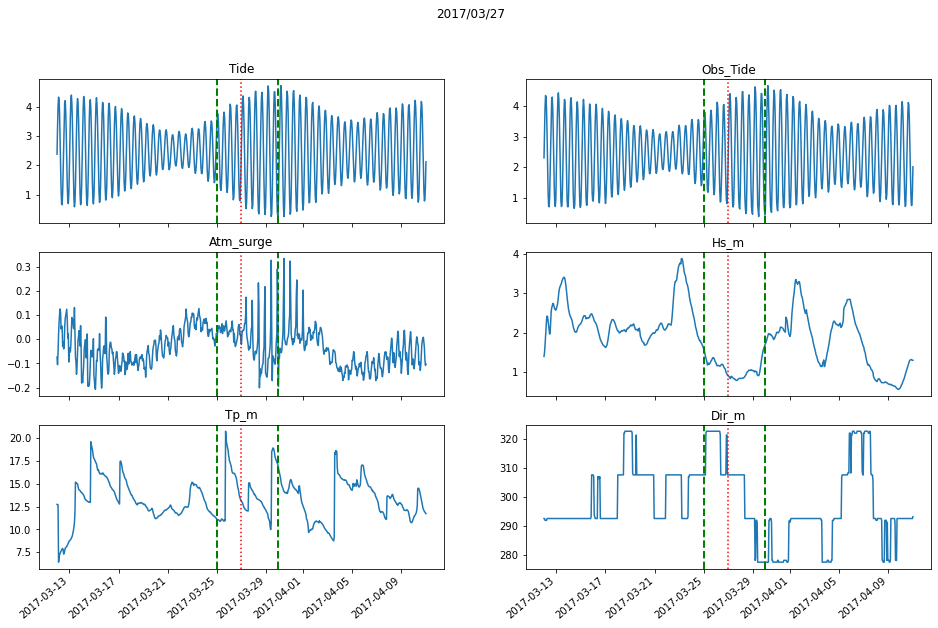

In [13]:
date_vec = "2017/03/27"
temp_df = full_df[full_df.Bathy == date_vec]
ncols=2
nrows = 3
var_vec = ['Tide', 'Obs_Tide', 'Atm_surge', 'Hs_m', 'Tp_m', 'Dir_m']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10),sharey=False)
fig.autofmt_xdate(rotation=40)
axes = axes.flatten()

for i, var in enumerate(var_vec):
    axes[i].plot_date('Date', var, fmt='-', data = temp_df)
    axes[i].axvline(pd.to_datetime(date_vec), color='r', linestyle='dotted')
    axes[i].axvline(pd.to_datetime("2017/03/25"), color='g', linestyle='--',linewidth=2)
    axes[i].axvline(pd.to_datetime("2017/03/30"), color='g', linestyle='--',linewidth=2)
    axes[i].set_title(var)
    
fig.suptitle(date_vec) 

Text(0.5, 0.98, '2018/01/31')

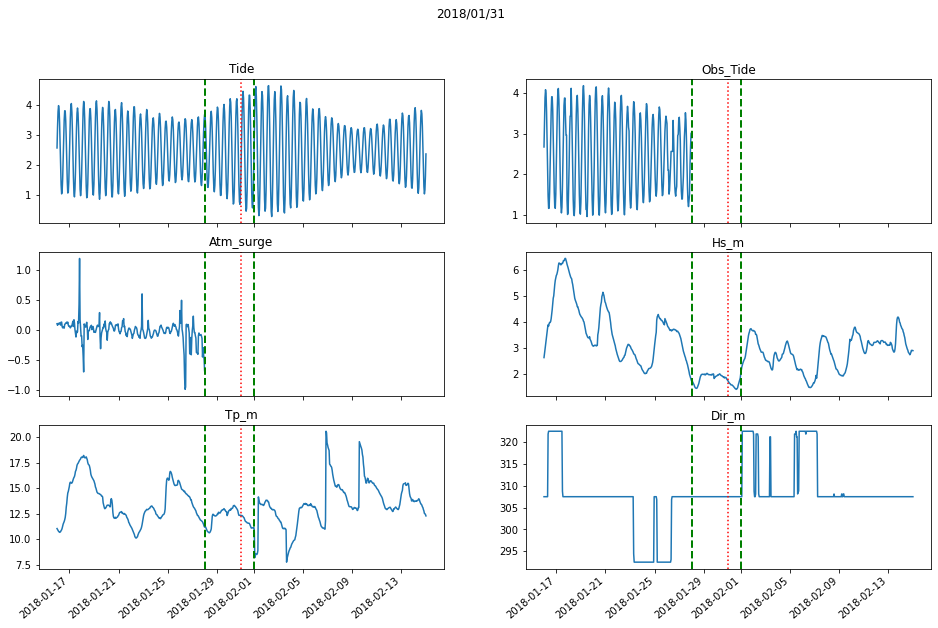

In [14]:
date_vec = "2018/01/31"
temp_df = full_df[full_df.Bathy == date_vec]
ncols=2
nrows = 3
var_vec = ['Tide', 'Obs_Tide', 'Atm_surge', 'Hs_m', 'Tp_m', 'Dir_m']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10),sharey=False, sharex=True)
fig.autofmt_xdate(rotation=40)
axes = axes.flatten()

for i, var in enumerate(var_vec):
    axes[i].plot_date('Date', var, fmt='-', data = temp_df)
    axes[i].axvline(pd.to_datetime(date_vec), color='r', linestyle='dotted')
    axes[i].axvline(pd.to_datetime("2018/01/28"), color='g', linestyle='--',linewidth=2)
    axes[i].axvline(pd.to_datetime("2018/02/01"), color='g', linestyle='--',linewidth=2)
    axes[i].set_title(var)
    
fig.suptitle(date_vec) 

Text(0.5, 0.98, '2021/03/03')

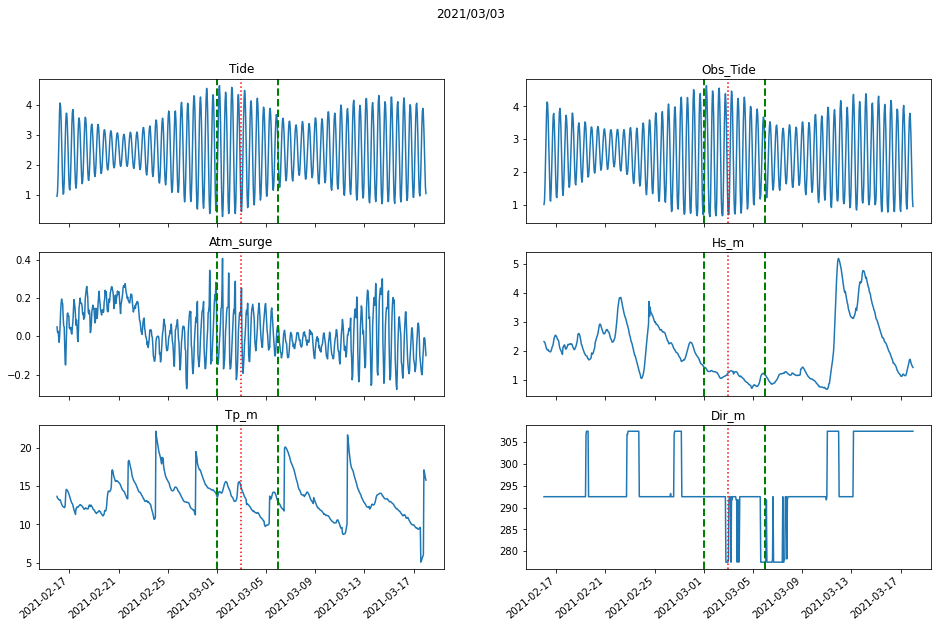

In [15]:
date_vec = "2021/03/03"
temp_df = full_df[full_df.Bathy == date_vec]
ncols=2
nrows = 3
var_vec = ['Tide', 'Obs_Tide', 'Atm_surge', 'Hs_m', 'Tp_m', 'Dir_m']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10),sharey=False)
fig.autofmt_xdate(rotation=40)
axes = axes.flatten()

for i, var in enumerate(var_vec):
    axes[i].plot_date('Date', var, fmt='-', data = temp_df)
    axes[i].axvline(pd.to_datetime(date_vec), color='r', linestyle='dotted')
    axes[i].axvline(pd.to_datetime("2021/03/01"), color='g', linestyle='--',linewidth=2)
    axes[i].axvline(pd.to_datetime("2021/03/06"), color='g', linestyle='--',linewidth=2)
    axes[i].set_title(var)
    
fig.suptitle(date_vec) 

Text(0.5, 0.98, '2021/06/21')

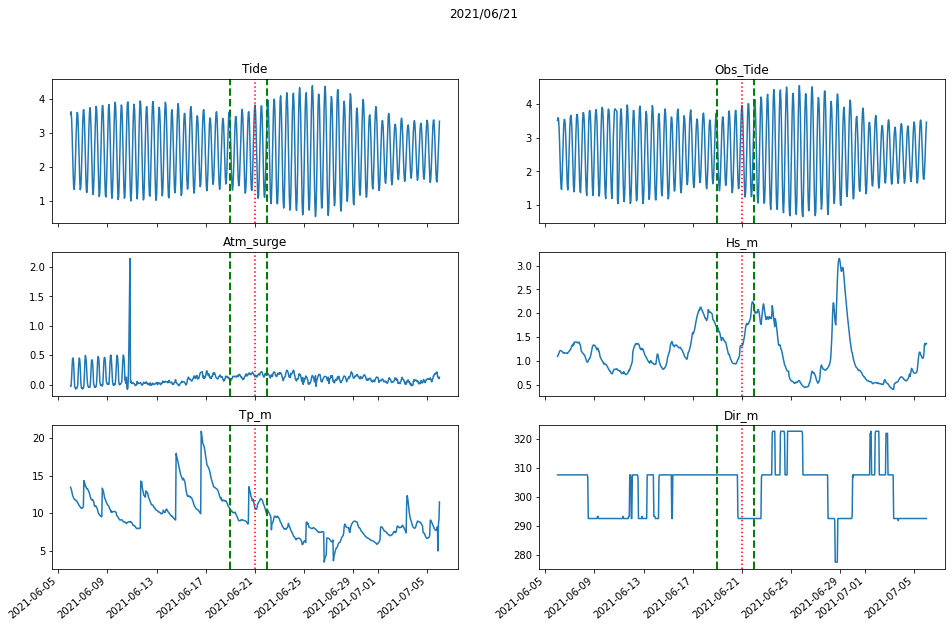

In [16]:
date_vec = "2021/06/21"
temp_df = full_df[full_df.Bathy == date_vec]
ncols=2
nrows = 3
var_vec = ['Tide', 'Obs_Tide', 'Atm_surge', 'Hs_m', 'Tp_m', 'Dir_m']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10),sharey=False)
fig.autofmt_xdate(rotation=40)
axes = axes.flatten()

for i, var in enumerate(var_vec):
    axes[i].plot_date('Date', var, fmt='-', data = temp_df)
    axes[i].axvline(pd.to_datetime(date_vec), color='r', linestyle='dotted')
    axes[i].axvline(pd.to_datetime("2021/06/19"), color='g', linestyle='--',linewidth=2)
    axes[i].axvline(pd.to_datetime("2021/06/22"), color='g', linestyle='--',linewidth=2)
    axes[i].set_title(var)
    
fig.suptitle(date_vec) 